In [1]:
%matplotlib inline
datadir = './data/'

import urllib.request, os, gzip

def download_data(dataset_name, datadir):
    filename = 'reviews_%s_5.json' % dataset_name
    filepath = os.path.join(datadir, filename)
    if os.path.exists(filepath):
        print("Dataset %s has already been downloaded to %s" % (dataset_name, datadir))
    else:
        url = 'http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/%s.gz' % filename
        urllib.request.urlretrieve(url, filepath + ".gz")
        with gzip.open(filepath + ".gz", 'rb') as fin:
            with open(filepath, 'wb') as fout:
                fout.write(fin.read())
        print("Downloaded dataset %s and saved it to %s" % (dataset_name, datadir))

dataset = "Baby"
download_data(dataset, datadir)

Dataset Baby has already been downloaded to ./data/


In [2]:
import  json

def  load_data (dataset_name, datadir):
    filepath = os.path.join(datadir, 'reviews_%s_5.json' % dataset_name)
    if not os.path.exists(filepath):
        download_data(dataset_name, datadir)
    data = []
    with open(filepath, 'r') as f:
        for line in f:                            # read file line by line
            item_hash = hash(line)                # we will use this later for partitioning our data 
            item = json.loads(line)               # convert JSON string to Python dict
            item['hash'] = item_hash              # add hash for identification purposes
            data.append(item)
    print("Loaded %d data for dataset %s" % (len(data), dataset_name))
    return data

# load the data...
baby = load_data(dataset, datadir)


Loaded 160792 data for dataset Baby


In [3]:
def partition_train_validation_test(data):
    # 60% : modulus is 0, 1, 2, 3, 4, or 5
    data_train = [item for item in data if item['hash']%10<=5]  
    # 20% : modulus is 6 or 7
    data_valid = [item for item in data if item['hash']%10 in [6,7]] 
    # 20% : modulus is 8 or 9
    data_test  = [item for item in data if item['hash']%10 in [8,9]] 
    return data_train, data_valid, data_test
    
baby_train, baby_valid, baby_test = partition_train_validation_test(baby)


In [4]:
from  nltk.corpus  import opinion_lexicon
positive_words = set(opinion_lexicon.positive())
negative_words = set(opinion_lexicon.negative())

import random
random.seed(1234)
print("Some positive words:", ", ".join(random.sample(positive_words, 10)))
print("Some negative words:", ", ".join(random.sample(negative_words, 10)))


Some positive words: proactive, solidarity, stronger, winners, intelligible, novelty, exceeding, trophy, calm, evocative
Some negative words: deficiency, unnerve, delusional, negligent, overzealously, gawk, punk, arduously, fastidious, mindless


In [5]:
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
eng_stopwords = set(stopwords.words('english'))

def my_tokenize(text):
    # split text into lower-case tokens, removing all-punctuation tokens and stopwords
    tokens = []
    for sentence in sent_tokenize(text):
        tokens.extend(x for x in word_tokenize(sentence.lower()) 
                      if x not in eng_stopwords and any(i.isalpha() for i in x))
    return tokens

def pos_neg_fraction(text):
    tokens = my_tokenize(text)
    count_pos, count_neg = 0, 0
    for t in tokens:
        if t in positive_words:
            count_pos += 1
        if t in negative_words:
            count_neg += 1
    count_all = len(tokens)
    if count_all != 0:
        return count_pos/count_all, count_neg/count_all
    else:
        return 0., 0.
    
pos_example = 'This is a good, great, fantastic, amazing, wonderful, super product!!!'
neg_example = 'This is a bad, atrocious, terrible, dreadful, awful, abysmal product!!!'
print(pos_neg_fraction(pos_example))
print(pos_neg_fraction(neg_example))

(0.8571428571428571, 0.0)
(0.0, 0.8571428571428571)


In [6]:
import numpy

def dataset_to_matrix(data):
    return numpy.array([list(pos_neg_fraction(item['reviewText'])) for item in data])

X_train = dataset_to_matrix(baby_train) # We use only the train part
most_pos, most_neg = numpy.argmax(X_train, axis=0)
# print the example with the highest fraction of positive words:
print("We found a fraction of %f %% positive words for example %d" % 
      (100.*X_train[most_pos, 0], most_pos))
print(baby_train[most_pos])
print("We found a fraction of %f %% negative words for example %d" %
      (100.*X_train[most_neg, 1], most_neg))
print(baby_train[most_neg])

We found a fraction of 100.000000 % positive words for example 5894
{'reviewerID': 'AKU0ZZ3IEZW42', 'asin': 'B0001BUKA8', 'helpful': [0, 0], 'reviewText': 'useful peace', 'overall': 5.0, 'summary': 'Five Stars', 'unixReviewTime': 1405382400, 'reviewTime': '07 15, 2014', 'hash': 8143300967346285803}
We found a fraction of 100.000000 % negative words for example 32016
{'reviewerID': 'A21QYR34ZVII0P', 'asin': 'B001CJKE40', 'reviewerName': 'Imelda', 'helpful': [0, 0], 'reviewText': 'Useless...', 'overall': 2.0, 'summary': 'Two Stars', 'unixReviewTime': 1404518400, 'reviewTime': '07 5, 2014', 'hash': -7394705115583839219}


In [7]:
def dataset_to_targets(data):
    return numpy.array([item['overall'] for item in data])

Y_train = dataset_to_targets(baby_train)
print("Our feature matrix is two-dimensional and has shape", X_train.shape)
print("Our target vector is one-dimensional and has shape", Y_train.shape)

Our feature matrix is two-dimensional and has shape (96755, 2)
Our target vector is one-dimensional and has shape (96755,)


 D_train that is true if the customer is **dissatisfied** (1, 2 or 3 stars), and false if the customer is satisfied (4 stars or better):

In [8]:
def discretize_targets(Y):
    return Y<=3.0

D_train = discretize_targets(Y_train)
print("The training data contains %f %% dissatisfied customers" % (100.*D_train.mean()))


The training data contains 21.288822 % dissatisfied customers


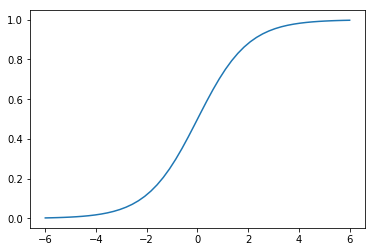

In [9]:
import pandas
points = numpy.linspace(-6.0, 6.0)
logistic_function = pandas.Series(1/(numpy.exp(-points)+1), index=points)
logistic_function.plot()

In [10]:
from sklearn.linear_model import LogisticRegression

logreg= LogisticRegression().fit(X_train,D_train)

#The predict_proba() method produces a matrix with two columns
#the first column contains the probaolity for the label being "fals""(satisfied costumer)
# the second column contains the probability for the label being "true" (dissatisfied customer)
# the sum of both columns is 1
#we select the second column with [:,1]
# [:,0] would select the first column
#[1,:] would select the second row

prob2_train = logreg.predict_proba(X_train)[:,1]
pred2_train = prob2_train > 0.5 # esto es un bool que da true o false
max_prob2 = numpy.argmax(prob2_train) # to test
min_prob2= numpy.argmin(prob2_train) # to test

def analyze_training_example_2(i):
    print("Training example number",i)
    print("True rating %f stars" %Y_train[i])
    print("Expected to be dissatisfied:", pred2_train[i])
    print("Expected probability of being dissatisfied : %f" % prob2_train[i])
    print("Features = %f / %f" % (X_train[i,0], X_train[i,1]))
    print("Review text = %s" % baby_train[i]['reviewText'])
    
analyze_training_example_2(max_prob2)

Training example number 32016
True rating 2.000000 stars
Expected to be dissatisfied: True
Expected probability of being dissatisfied : 0.999862
Features = 0.000000 / 1.000000
Review text = Useless...


In [11]:
analyze_training_example_2(min_prob2)

Training example number 5894
True rating 5.000000 stars
Expected to be dissatisfied: False
Expected probability of being dissatisfied : 0.000037
Features = 1.000000 / 0.000000
Review text = useful peace


In [12]:
# Recall.. how many (%) dissatisfied custumers did we identified as dissatisfed
#Precision... of all the identified as "dissatisfied", which porcetage was actually dissatisfied
from sklearn.metrics import precision_score, recall_score
precision2 = precision_score(D_train,pred2_train)
recall2 = recall_score(D_train,pred2_train)
print("For the default threshold (0.5) we get precision = %f "
      "and recall = %f" % (precision2, recall2))

For the default threshold (0.5) we get precision = 0.600246 and recall = 0.094621


60% of the ones we said were not satisfied were dissatisfied ( so actually around 40% were sattisfied)
10%  of the dissatisfied costumers were correctly labled by our algorithm (we left almost 90% out)

Precision as function of threshold: 


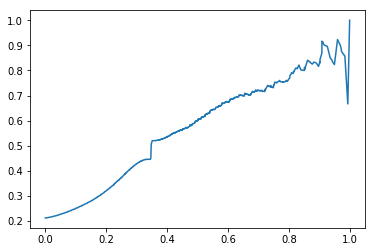

In [13]:
from sklearn.metrics import precision_recall_curve
all_precision2, all_recall2, all_thresh2 = precision_recall_curve(
    D_train, prob2_train)
print("Precision as function of threshold: ")
pandas.Series(all_precision2[:-1], index = all_thresh2).plot()

Recall as function of threshold:


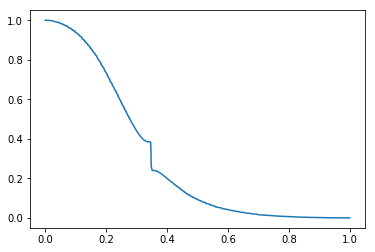

In [14]:
print("Recall as function of threshold:")
pandas.Series(all_recall2[:-1], index=all_thresh2).plot()

Recall as function of precision:


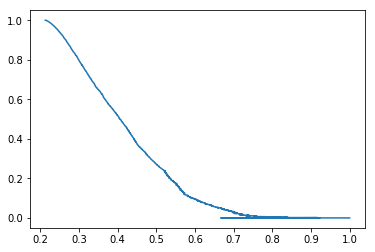

In [15]:
print("Recall as function of precision:")
pandas.Series(all_recall2[:-1], index=all_precision2[:-1]).plot()

Now the precision is 0.486217 and the recall is 0.154141


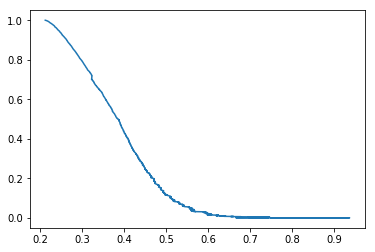

In [16]:
from sklearn.naive_bayes import GaussianNB, BernoulliNB
nb = GaussianNB().fit(X_train, D_train)
prob3_train = nb.predict_proba(X_train)[:,1]
pred3_train = prob3_train >0.5
precision3 = precision_score(D_train, pred3_train)
recall3 = recall_score(D_train,pred3_train)
print("Now the precision is %f and the recall is %f" % (precision3, recall3))
all_precision3, all_recall3, all_thresh3 = precision_recall_curve(
    D_train, prob3_train)
pandas.Series(all_recall3[:-1], index=all_precision3[:-1]).plot()

In [19]:
import tensorflow as tf
feat_cols = [tf.feature_column.numeric_column(key="fpos"),
            tf.feature_column.numeric_column(key="fneg")]
model = tf.estimator.LinearRegressor(feature_columns =feat_cols)

get_training_data = tf.estimator.inputs.numpy_input_fn(
                        x={"fpos" : X_train[:,0], "fneg" : X_train[:,1]},
                        y = Y_train, num_epochs = None, shuffle = True 
                        )

model.train(input_fn = get_training_data, steps = 5000)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\MAGUIL~1\\AppData\\Local\\Temp\\tmp27utl1i2', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x0000023BF0D8A630>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 

In [20]:
eval_training_data = tf.estimator.inputs.numpy_input_fn(
                     x={"fpos":X_train[:,0], "fneg": X_train[:,1]},
                     num_epochs=1, shuffle=False)
pred_train_tf = numpy.array([item['predictions'][0] for item in 
                         model.predict(input_fn=eval_training_data)])
mae_train_tf = mean_absolute_error(pred_train_tf, Y_train)
print("The mean absolute error on the training data is %f stars" 
      % mae_train_tf)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\MAGUIL~1\AppData\Local\Temp\tmp27utl1i2\model.ckpt-5000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


NameError: name 'mean_absolute_error' is not defined